#Travel Insurance predictive analysis

The goal of this analysis is to find out whether we can predict which consumers will take a travel insurance, based on several geographic and behavioural characteristics of current travel insurance holders and non-holders.

The amount of features to base predictions on in this dataset is fairly small, just 8. Therefore, our dataset is likely not covering the full amount of features that influence their decision whether to take an insurance. Data used for this project can be found [here](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)

In [ ]:
pip install eli5

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, roc_auc_score, accuracy_score, get_scorer_names
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, BaggingClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
sns.set_style('white')
sns.set_palette("ch:.25")
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.3f}'.format

# Part 1: Data exploration

In [ ]:
travel = pd.read_csv("/content/drive/MyDrive/colab_data_sources/TravelInsurancePrediction.csv")
print('There are {} rows and {} columns in this dataset.' .format(travel.shape[0], travel.shape[1]))

There are 1987 rows and 10 columns in this dataset.


In [ ]:
travel.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [ ]:
travel['Budget_per_familyMember'] = travel['AnnualIncome']/travel['FamilyMembers']

In [ ]:
travel = travel.rename(columns={'Employment Type':'EmploymentType'})
travel= travel.drop(columns=('Unnamed: 0'))

In [ ]:
full_duplicates = travel.duplicated().sum()
print('There are',full_duplicates, 'fully duplicated cases.')

There are 738 fully duplicated cases.


In [ ]:
travel = travel.drop_duplicates(keep='first')

In [ ]:
travel['id'] = range(1, len(travel) + 1)

In [ ]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249 entries, 0 to 1985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1249 non-null   int64  
 1   EmploymentType           1249 non-null   object 
 2   GraduateOrNot            1249 non-null   object 
 3   AnnualIncome             1249 non-null   int64  
 4   FamilyMembers            1249 non-null   int64  
 5   ChronicDiseases          1249 non-null   int64  
 6   FrequentFlyer            1249 non-null   object 
 7   EverTravelledAbroad      1249 non-null   object 
 8   TravelInsurance          1249 non-null   int64  
 9   Budget_per_familyMember  1249 non-null   float64
 10  id                       1249 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 117.1+ KB


We have almost 2000 cases, no missing values and quite a few objects features, below we check out the categories of each.



In [ ]:
for col in travel.columns:
    if travel[col].dtype == 'object':
        print(f"{col}: {travel[col].unique()}")

EmploymentType: ['Government Sector' 'Private Sector/Self Employed']
GraduateOrNot: ['Yes' 'No']
FrequentFlyer: ['No' 'Yes']
EverTravelledAbroad: ['No' 'Yes']


It looks like all categorical features are binary, and three of them yes/no. The levels of GraduateOrNot are swiped compared to the other two yes/no features, we will modify this to be in line with the other features, and turn it into an integer.

Below we check out ranges and descriptive statistics of continuous features.

### Numerical features

In [ ]:
travel.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Budget_per_familyMember,id
count,"1,249.000","1,249.000","1,249.000","1,249.000","1,249.000","1,249.000","1,249.000"
mean,29.756,"934,547.638",4.890,0.333,0.387,"220,580.893",625.000
std,2.921,"360,729.284",1.762,0.471,0.487,"128,751.999",360.700
min,25.000,"300,000.000",2.000,0.000,0.000,"33,333.333",1.000
25%,28.000,"600,000.000",4.000,0.000,0.000,"128,571.429",313.000
50%,29.000,"900,000.000",5.000,0.000,0.000,"200,000.000",625.000
75%,32.000,"1,200,000.000",6.000,1.000,1.000,"275,000.000",937.000
max,35.000,"1,800,000.000",9.000,1.000,1.000,"875,000.000","1,249.000"


* Looking at the TravelInsurance feature first, we can see from the mean that 35% of cases in our dataset has a travel insurance, and 65% don't. Thus this is slightly unbalanced.
* ChronicDiseases and TravelInsurance turn out to be binary features too, looking at the range of 0-1, we will assume that 0 and 1 respectively mean no and yes.
* The amount of family members per case is varying between 2-9, with 5 (4.8) on average.
* Annual income varies from 300k to 1.8M, with the median and average both almost a million in an unknown valuta.
* Age ranges from 25 to 35, with an average and median of 29. We wonder whether this feature is normally distributed.
* It seems 28% of cases on our sample has a chronic disease, we might wonder whether these people are more likely to take a travel insurance.

In [ ]:
mapping = {0: 'No', 1: 'Yes'}
travel['ChronicDiseases'] = travel['ChronicDiseases'].map(mapping).sort_values()

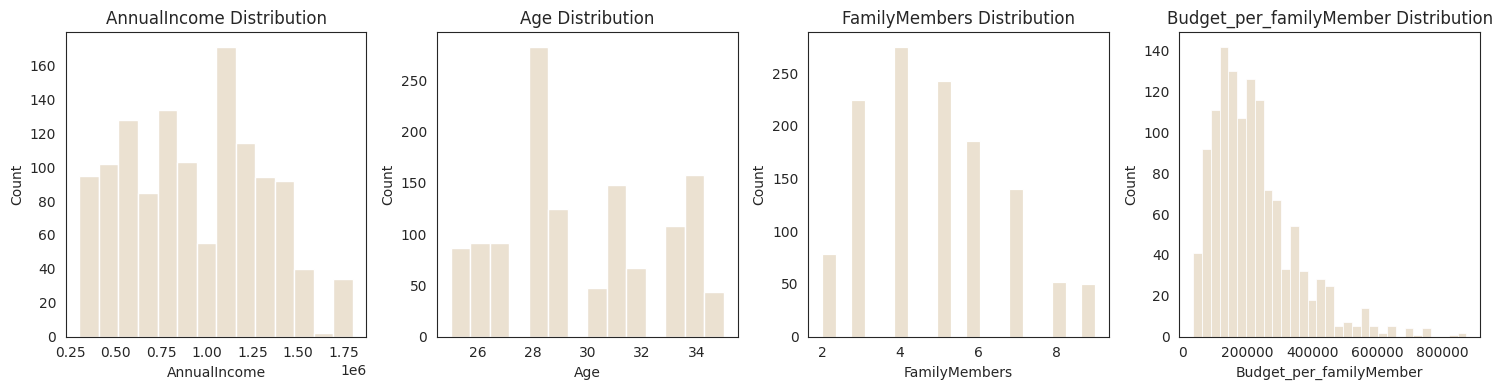

In [ ]:
variables_to_plot = ['AnnualIncome', 'Age', 'FamilyMembers', 'Budget_per_familyMember']
num_subplots = len(variables_to_plot)

plt.figure(figsize=(15, 4))

for i, variable in enumerate(variables_to_plot, start=1):
    plt.subplot(1, num_subplots, i)
    sns.histplot(x=travel[variable])
    plt.title(f'{variable} Distribution')

plt.tight_layout()
plt.show();

* The annual income distribution does not seem to follow a normal distribution, perhaps a polynomial.
* For age, it is also hard to detect a pattern. Clearly 28 is the mode and 34 year olds are second most represented. The median and max ages of 30 and 35 respectivly are least common.
* The familymembers feature is the only that looks normally distributed, with 4 familymembers as the mode. With the median of 5, and the highest values of 8 and 9 least common, the distribution is slightly right-skewed.

Next, we will compare the spread of cases that do have an insurance with cases that don't. We need to keep in mind here that the group sizes differ, there are less insurance holders than non-holders.

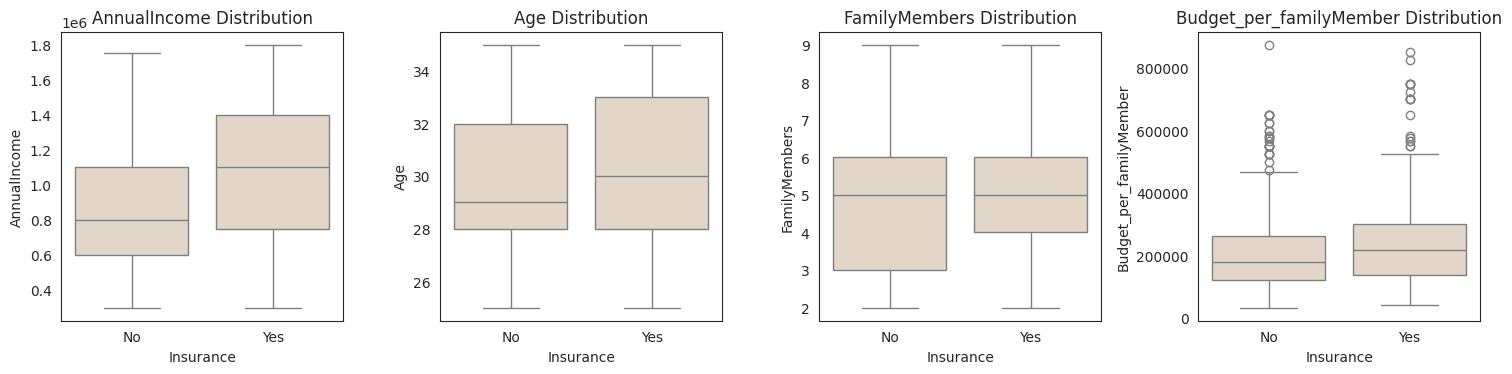

In [ ]:
travel['Insurance'] = travel['TravelInsurance'].map({0: 'No', 1: 'Yes'})
num_subplots = len(variables_to_plot)

plt.figure(figsize=(15, 4))

for i, variable in enumerate(variables_to_plot, start=1):
    plt.subplot(1, num_subplots, i)
    sns.boxplot(x=travel.Insurance, y=travel[variable])
    plt.title(f'{variable} Distribution')

plt.tight_layout()
plt.show();

* While for travel insurance holders and non-holders the income range is similar, insurance holders clearly have a higher median income, with iqr in a higher range than non-holders. Thus, we could hypothesize that income impacts the decision to take travel insurance.
* The median age of people without insurance is slightly lower than for people with insurance. The age distribution for insurance holders is more spread with the median of 30 being exactly the middle of the range.
* The amount of family members is similarly spread for both insurance holders and non-holders. Thus, this feature is expected to have much predictive value.

Next we will look at distributions per feature level, to see if we can find any patterns or anomalies.

In [ ]:
table = pd.crosstab(travel['TravelInsurance'], travel['Age'], normalize='columns').style.background_gradient(cmap='cividis')
age_table = table.format({col: "{:.0%}" for col in table.columns})
age_table

Age,25,26,27,28,29,30,31,32,33,34,35
TravelInsurance,,,,,,,,,,,
0,41%,58%,75%,71%,66%,60%,66%,72%,49%,51%,45%
1,59%,42%,25%,29%,34%,40%,34%,28%,51%,49%,55%


Taking a closer look at age, we notice the following:
* Only age 25, 33 and 35 see a higher amount people that do have travel insurance than don't.
* The largest proportions of people without insurance are aged 27, 28 and 32.
In conclusion, no clear pattern can be detected based on age. We have to make a note though that the age range in this dataset is very narrow, over the entire population this could even be a cluster.

In [ ]:
table = pd.crosstab(travel['TravelInsurance'], travel['FamilyMembers'], normalize='columns').style.background_gradient(cmap='cividis')
FamilyMembers_table = table.format({col: "{:.0%}" for col in table.columns})
FamilyMembers_table

FamilyMembers,2,3,4,5,6,7,8,9
TravelInsurance,,,,,,,,
0,71%,63%,63%,67%,56%,49%,63%,52%
1,29%,37%,37%,33%,44%,51%,37%,48%


For each amount of familymembers, there are more cases without insurance. However, it seems like the more familymembers, the larger the relative proportion of cases that does have insurance. We might wonder whether this is because the costs and inconvenience involved with irregularities on holiday are estimated to be higher with more people, the risk of it higher or group pressure.

In [ ]:
ranges = range(0, 1800001, 300000)
group_names = ['0-300k', '300k-600k', '600k-900k', '900k-1200k', '1200k-1500k', '1500k-1800k']
travel['income_groups'] = pd.cut(travel['AnnualIncome'], bins=ranges, labels=group_names)

In [ ]:
travel.groupby("income_groups").agg({'id': 'count', 'TravelInsurance': 'mean'}).rename(columns={'id': 'count'})

,count,TravelInsurance
income_groups,,
0-300k,31,0.161
300k-600k,294,0.269
600k-900k,322,0.317
900k-1200k,293,0.314
1200k-1500k,269,0.665
1500k-1800k,40,0.650


* When dividing the income range up in 6 equal classes, we notice that incomes in general are actually quite evenly spread in this dataset, with only the lowest and highest class being smaller.
* We can see that in the lowest income category only 6% has a travel insurance, while in the higest two this is over 70%. In the middle ranges around 25% has a travel insurance.

### Categorical features

All categorical features turn out to be binary, except for the newly created income groups.

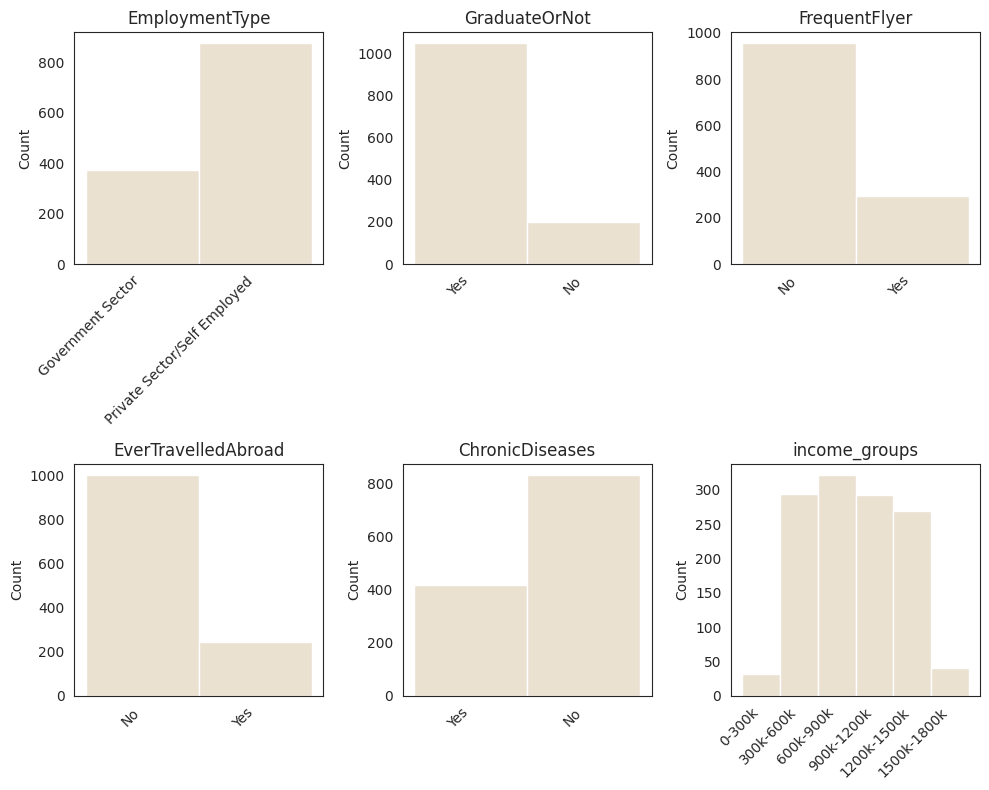

In [ ]:
binary_features = ['EmploymentType', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad', 'ChronicDiseases', 'income_groups']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,8))

for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        binary_feature = binary_features[i * 3 + j]
        sns.histplot(x=binary_feature, data=travel, ax=ax)
        ax.set_title(f'{binary_feature}')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

We notice that of the total cases in our dataset:
* The majority, about 3/4, is employed in the private sector.
* The majority is graduated.
* Only about one fifth is frequent flyer.
* Only about one fifth has travelled abroad.
* About one fourth has a chronic disease.

In [ ]:
pd.crosstab(travel.EverTravelledAbroad, travel.TravelInsurance)

TravelInsurance,0,1
EverTravelledAbroad,,
No,689,316
Yes,77,167


* What seems surprising is that the majority of cases in our dataset has never travelled abroad.
* However, looking at the within-group variation, we can see that of the total amount of people that does travel abroad a higher proportion has insurance, than in the group that does not travel abroad.
* We might wonder based on this feature EverTravelledAbroad, whether the dataset is representative of the population.
However, from the information with our dataset we do not know much about the context of the dataset in terms of geographics, date range etc. If the data is from decades back, it might not be as uncommon to not have travelled abroad. Or in a large country like the US it might be much more likely that people never travelled abroad than in a European country.



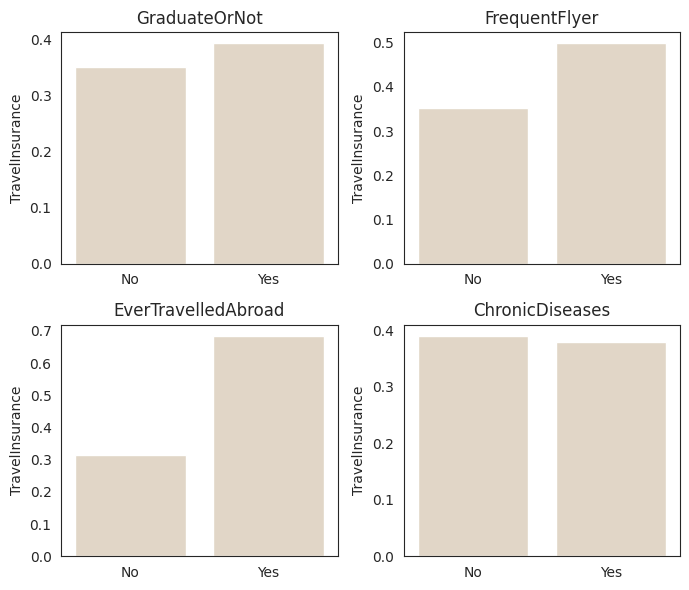

In [ ]:
binary_features = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad', 'ChronicDiseases']

order = ['No', 'Yes']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        binary_feature = binary_features[i * 2 + j]
        sns.barplot(x=binary_feature, y='TravelInsurance', data=travel, ax=ax, ci=None, order=order)
        ax.set_title(f'{binary_feature}')
        ax.set_xlabel('')
plt.tight_layout()
plt.show()

Looking more specifically only at cases that do have a travel insurance, we notice they more often than not:
* are Graduated
* are Frequent flyers
* Have travelled abroad
* almost no difference in chronic diseases

In conclusion, only the fact that the majority is graduated they have in common with the total sample. In terms of frequent flying, travelling abroad and chronic diseases, this group shows the opposite pattern. Thus, this seems to indicate that people that have a travel insurance are differing from the overall population in some aspects.

In [ ]:
pd.crosstab(travel.EmploymentType, travel.TravelInsurance)

TravelInsurance,0,1
EmploymentType,,
Government Sector,250,123
Private Sector/Self Employed,516,360


We can see that many more people in the private sector versus the public have travel insurance. However, looking at the spread within these groups, in both the public and private sectors the majority does not have travel insurance.

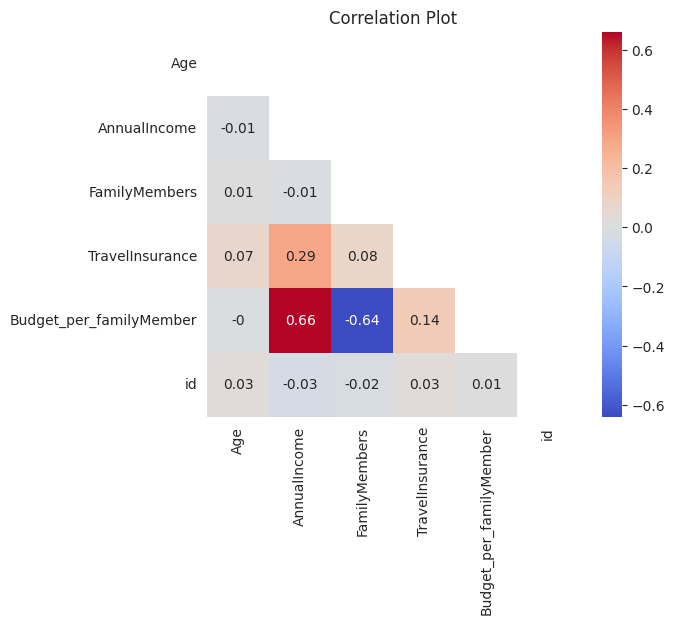

In [ ]:
plt.figure(figsize=(6, 5))
corr_matrix = travel.corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

* Only annual income seems to be correlated with travel insurance slightly at 0.4.
* Budget per familymember logically is somewhat correlated with income and amount of familymembers, however not very strongly.

# Part 2: Data pre-processing

The aim of this project is to create a model to predict as accurate as possible who is more likely to get a travel insurance and who not, to ultimately be able predict this for potential new customers.

We will use the data we have of people that do and don't have a travel insurance to train a prediction model.

The TravelInsurance feature will serve as the target feature, which is binary with values representing our classes to be predicted:
- 0: no insurance
- 1: insurance

Firstly, we will prepare the dataset to be used in a binary classification model, creating a train-test split and a pre-processing pipeline.

In [ ]:
travel_model = travel.copy().drop(columns=(['id', 'income_groups', 'Insurance']))
travel_model['TravelInsurance'].value_counts(normalize=True)

0   0.613
1   0.387
Name: TravelInsurance, dtype: float64

* The classes of our target feature are imblanced, with only 36% having an insurance and 64% not. However, we will not try to artificially restore the balance, as this could increase the likelihood of our model to be overfitting and therefore having low predictive accuracy.
* We will use the stratify= hyperparameter when creating a train-test split, to make sure the minor category does not become even smaller in either the train or test set.

In [ ]:
train_set, test_set = train_test_split(travel_model, test_size=0.2, random_state = 2, stratify=travel_model['TravelInsurance'])
print("n training set: ",len(train_set))
print("n test set: ",len(test_set))

X_train = train_set.drop("TravelInsurance", axis=1)
y_train = train_set["TravelInsurance"].copy()

num_features = X_train.select_dtypes(include=['float64', 'int64'])
text_features = X_train.select_dtypes(include=['object'])

n training set:  999
n test set:  250


## Pipeline

In order to have all features processed in a similar way, we will create a pipeline for it.

--> justify choice for transformers like standardscaler, why not minmax or normalizer?

In [ ]:
num_attribs = list(num_features)
cat_attribs = list(text_features)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

full_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train = full_pipeline.fit_transform(X_train)

In [ ]:
feature_names = list(full_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_attribs))

In [ ]:
all_feature_names = num_attribs + feature_names
df_transformed = pd.DataFrame(X_train, columns=all_feature_names)

In [ ]:
X_test = test_set.drop("TravelInsurance", axis=1)
y_test = test_set["TravelInsurance"].copy()

X_test = full_pipeline.fit_transform(X_test)

## Performance evaluation functions

# check standard for writing functions

In [ ]:
def classification_evaluation(model_name, x, y, pred_labels):

  cm = confusion_matrix(y, pred_labels)
  fig, ax = plt.subplots(figsize=(3,3))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='white')

  accuracy = model_name.score(x, y)
  print('Accuracy: {:.2f}%\n'.format(model_name.score(x, y)*100))
  print('Classification report:\n', classification_report(y, pred_labels, zero_division=0))

def ROC_AUC(y, prob_y):
  fpr, tpr, thresholds = roc_curve(y, prob_y,
                                 pos_label=1)
  roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

  ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
  ax.set_ylim(0, 1)
  ax.set_xlim(1, 0)
  ax.plot((1, 0), (0, 1))
  ax.set_xlabel('specificity')
  ax.set_ylabel('recall')
  ax.set_title('ROC curve');

  AUC = roc_auc_score([1 if yi == 1 else 0 for yi in y], prob_y)
  print('AUC: {:.2f}\n'.format(AUC))

# Part 3: Data Modelling

We will now use different classficiation algorithms to fit a model on our dataset, in order to find out which is best at predicting cases that do and don't have a travel insurance.

We will use 10 fold cross-validation for each model, meaning the training set will be split into 10 subsets or folds, then 10 times a model is trained on 9 folds and 1 is left out for validation. On the last one, predictions are made and the model is being evaluated, until each fold has been used for evaluation once.

For each model, we then calculate the mean of these 10 accuracy scores and compare it the to the training set accuracy, in order to see if the model is overfitting on the training data.

For the hyperparameters, default values are used wherever possible.

## KNN

In [ ]:
knn = KNeighborsClassifier()
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=10,
                       n_jobs=-1)
print('cv mean accuracy: {:.2f}'.format(cv_scores_knn.mean()))

cv mean accuracy: 0.69


Accuracy: 66.80%

Classification report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75       153
           1       0.59      0.46      0.52        97

    accuracy                           0.67       250
   macro avg       0.65      0.63      0.63       250
weighted avg       0.66      0.67      0.66       250



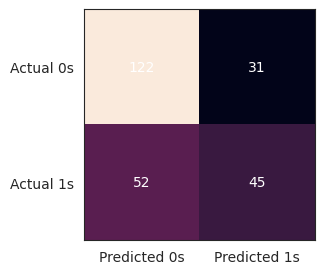

In [ ]:
knn_model = knn.fit(X_train, y_train)
prediction_labels = knn_model.predict(X_test)
classification_evaluation(knn_model, X_test, y_test, prediction_labels)

## Logistic regression

In [ ]:
logistic = LogisticRegression(solver='liblinear', C=1.0, random_state=2)

cv_scores_logistic = cross_val_score(logistic, X_train, y_train, cv=10,
                       n_jobs=-1)

print('cv mean accuracy: {:.2f}'.format(cv_scores_logistic.mean()))

cv mean accuracy: 0.70


Accuracy: 71.20%

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.79       153
           1       0.70      0.44      0.54        97

    accuracy                           0.71       250
   macro avg       0.71      0.66      0.67       250
weighted avg       0.71      0.71      0.69       250

AUC: 0.68



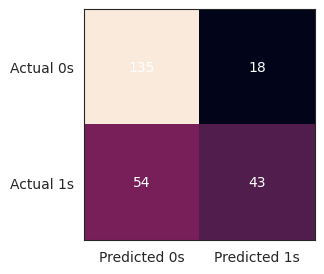

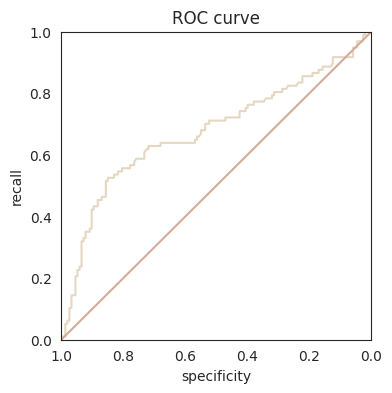

In [ ]:
logistic_model = logistic.fit(X_train, y_train)
pred_ylabels = logistic_model.predict(X_test)
y_pred = logistic_model.predict_proba(X_test)[:, 1]

classification_evaluation(logistic_model, X_test, y_test, pred_ylabels)
ROC_AUC(y_test, y_pred)

## Support vector classifiers

As the dataset is relatively small, we will also try support vector machine algorithms.
For this, we have different options:
* Linear support vector classifier
* Linear svc with polynomial features
* SVC with polynomial kernel
* SVC with RBF kernel

### Linear SVC

In [ ]:
lsvc = LinearSVC(C=1, loss="hinge", random_state=2)
cv_scores_lsvc = cross_val_score(lsvc,  X_train, y_train, cv=10,
                       n_jobs=-1)
print('cv linear support vector machine mean accuracy: {:.2f}'.format(cv_scores_lsvc.mean()))

cv linear support vector machine mean accuracy: 0.69


Accuracy: 68.40%

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.89      0.77       153
           1       0.67      0.36      0.47        97

    accuracy                           0.68       250
   macro avg       0.68      0.62      0.62       250
weighted avg       0.68      0.68      0.66       250



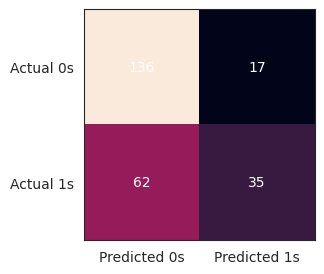

In [ ]:
lsvc_model = lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc_model.predict(X_test)
classification_evaluation(lsvc_model, X_test, y_test, y_pred_lsvc)

To try out the linear svm with polynomial features, we need to transform the features before scaling, thus this would require us to create a separate pre-processing pipeline specically for this model type, and run it on the raw training data.

Alternatively we can run a non-linear SVC with a polynomial kernel.

### SVC with polynomial kernel

In [ ]:
SVM = SVC(kernel="poly", probability=True, random_state=2)

cv_scores_svm = cross_val_score(SVM, X_train, y_train, cv=10,
                       n_jobs=-1)
print('cv polynomial support vector machine mean accuracy: {:.3f}'.format(cv_scores_svm.mean()))

cv polynomial support vector machine mean accuracy: 0.760


Accuracy: 72.40%

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.89      0.80       153
           1       0.73      0.46      0.57        97

    accuracy                           0.72       250
   macro avg       0.72      0.68      0.68       250
weighted avg       0.72      0.72      0.71       250



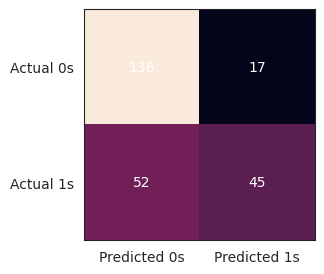

In [ ]:
SVM_model = SVM.fit(X_train, y_train)
y_pred_SVM = SVM_model.predict(X_test)
classification_evaluation(SVM_model, X_test, y_test, y_pred_SVM)

Accuracy improves when using a polynomial kernel.

### SVC with rbf kernel

Kernel chosen: radial basis function or Gaussian.

In [ ]:
SVC_rbf = SVC(kernel="rbf", probability=True, random_state=2)

cv_scores_rbf = cross_val_score(SVC_rbf, X_train, y_train, cv=10,
                       n_jobs=-1)
print('cv support vector machine mean accuracy: {:.3f}'.format(cv_scores_rbf.mean()))

cv support vector machine mean accuracy: 0.763


Accuracy: 72.40%

Classification report:
               precision    recall  f1-score   support

           0       0.72      0.90      0.80       153
           1       0.73      0.45      0.56        97

    accuracy                           0.72       250
   macro avg       0.73      0.67      0.68       250
weighted avg       0.73      0.72      0.71       250



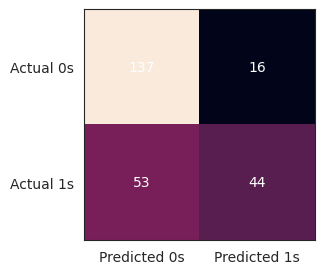

In [ ]:
SVC_rbf_model = SVC_rbf.fit(X_train, y_train)
y_pred_rbf = SVC_rbf_model.predict(X_test)
classification_evaluation(SVC_rbf_model, X_test, y_test, y_pred_rbf)

The cross-validated accuracy is only slightly higher than the test set accuracy, and than the polynomial kernel svc, knn and logistic models. The model might improve still when tuning hyperparameters.

## Decision tree

In [ ]:
decisiontree = DecisionTreeClassifier(random_state=0)

cv_scores = cross_val_score(decisiontree,  X_train, y_train, cv=10,
                       n_jobs=-1)
print('cv mean accuracy: {:.2f}'.format(cv_scores.mean()))

cv mean accuracy: 0.60


Accuracy: 55.60%

Classification report:
               precision    recall  f1-score   support

           0       0.62      0.69      0.65       153
           1       0.41      0.35      0.38        97

    accuracy                           0.56       250
   macro avg       0.52      0.52      0.52       250
weighted avg       0.54      0.56      0.55       250



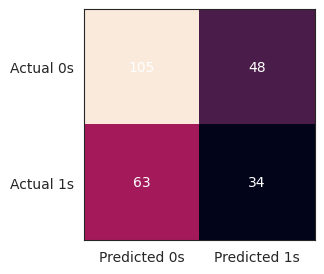

In [ ]:
decisiontree.fit(X_train, y_train)
y_pred_tree = decisiontree.predict(X_test)
classification_evaluation(decisiontree, X_test, y_test, y_pred_tree)

## Random forest

In [ ]:
rnd_clf = RandomForestClassifier(random_state=2)

cv_scores_rnd = cross_val_score(rnd_clf,  X_train, y_train, cv=10,
                       n_jobs=-1, scoring = 'accuracy')
print('cv mean accuracy: {:.3f}'.format(cv_scores_rnd.mean()))

cv mean accuracy: 0.649


Accuracy: 62.00%

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70       153
           1       0.51      0.46      0.49        97

    accuracy                           0.62       250
   macro avg       0.60      0.59      0.59       250
weighted avg       0.61      0.62      0.62       250



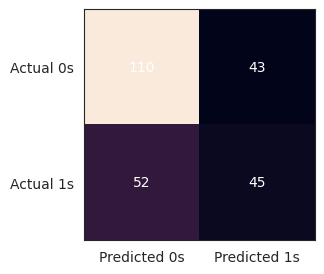

In [ ]:
rnd_model = rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_model.predict(X_test)
classification_evaluation(rnd_model, X_test, y_test, y_pred_rf)

The random forest is predicting a little more accurately than the single decision tree.

Next let's compare all models.

# Cross-validation overview

We will create an overview of cross-validation scores of all the previously run models. We will use AUC and precision in addition to accuracy, as our dataset is imbalanced.

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
roc_auc=[]
recall=[]
f1=[]
classifiers=['Linear Svc','Polynomial Svc','Radial Svc','Logistic Regression','KNN','Decision Tree','Random Forest']
models=[SVC(kernel='linear'), SVC(kernel='poly'),SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier()]
for model in models:
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "roc_auc")
    cv_result2 = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "recall")
    cv_result3 = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "f1")
    roc_auc.append(cv_result.mean())
    recall.append(cv_result2.mean())
    f1.append(cv_result3.mean())
cv_dataframe=pd.DataFrame({'AUC':roc_auc, 'recall':recall, 'f1':f1},index=classifiers)
cv_dataframe

,AUC,recall,f1
Linear Svc,0.678,0.345,0.456
Polynomial Svc,0.749,0.504,0.620
Radial Svc,0.741,0.508,0.620
Logistic Regression,0.696,0.417,0.515
KNN,0.700,0.512,0.560
Decision Tree,0.583,0.503,0.493
Random Forest,0.644,0.502,0.529


* We can see that the polynomial and radial SVC's, and random forest are highest in AUC, all three have roughly similar AUC of 0.79.
* The svc's also stand far out in terms of precision.
* In terms of accuracy, the polynomial and radial SVC's are highest as well, followed closely by random forest.


# Part 4: Hyperparameter tuning

We will now try to tune up the performance of two different model types that seemed to have relatively high cross-validated performance: the SVC with rbf kernel and the random forest. Grid search will be used to try out different combinations of hyperparameter values.
Accuracy will be used as a performance evaluation metric based on 10 fold cross-validation of the tuned models.

### RBF SVC
For the hyperparameter values in the parameter grid, we chose numbers differing by a power of 10, as suggested [here](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch02.html#idm45022188914664).
The kernel itself is not added as a hyperparameter, as when running two separate models for the rbf and poly kernels, the poly kernel model turned out to be so slow that we decided to eliminate it.

In [ ]:
params_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100]
}

grid_rbf = GridSearchCV(estimator=SVC_rbf,
                       param_grid=params_rbf,
                       scoring='f1',
                       cv=10,
                       n_jobs=-1)

In [ ]:
grid_rbf.fit(X_train, y_train)

best_hyperparams = grid_rbf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

best_CV_score = grid_rbf.best_score_
print('Best CV accuracy: {:.3f}'.format(best_CV_score))

Best hyperparameters:
 {'C': 1, 'gamma': 0.1}
Best CV accuracy: 0.618


In [ ]:
from sklearn.metrics import f1_score

tuned_rbf = grid_rbf.best_estimator_
test_rbf_acc = tuned_rbf.score(X_test, y_test)

f1_score = tuned_rbf.f1_score(y_test)
print("Test set accuracy of tuned rbf model: {:.3f}".format(test_rbf_acc))

AttributeError: 'SVC' object has no attribute 'f1_score'

The svc does not have higher accuracy when tuned compared to the model with default hyperparameter values. It might improve if we use a different array of values in our grid.

In [ ]:
updated_params_rbf = {
    'C': [5, 10, 20, 50],
    'gamma': [0.1, 0.2, 0.3]
}

grid_rbf_updated = GridSearchCV(estimator=SVC_rbf,
                       param_grid=updated_params_rbf,
                       scoring='accuracy',
                       cv=10,
                       n_jobs=-1)

In [ ]:
grid_rbf_updated.fit(X_train, y_train)

best_hyperparams = grid_rbf_updated.best_params_
print('Best hyperparameters:\n', best_hyperparams)

best_CV_score = grid_rbf_updated.best_score_
print('Best CV accuracy: {:.3f}'.format(best_CV_score))

In [ ]:
tuned_rbf = grid_rbf_updated.best_estimator_
test_rbf_acc = tuned_rbf.score(X_test, y_test)
print("Test set accuracy of tuned rbf model: {:.3f}".format(test_rbf_acc))

The second round of further tuning provided 1.6% improvement in accuracy.

### Random forest

In [ ]:
params_rnd =  {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
 random_search = RandomizedSearchCV(
    rnd_clf,
    param_distributions=params_rnd,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

best_hyperparams = random_search.best_params_
print('Best hyperparameters:\n', best_hyperparams)

best_CV_score = random_search.best_score_
print('Best CV accuracy: {:.3f}'.format(best_CV_score))

In [ ]:
tuned_rnd = random_search.best_estimator_
test_rnd_acc = tuned_rnd.score(X_test, y_test)
print("Test set accuracy of tuned rnd model: {:.3f}".format(test_rnd_acc))

The cross-validated accuracy and test set accuracy are similar, thus the model does not seem to be overfitting. The accuracy of the tuned random forest is a lot higher than the untuned random forest.

In [ ]:
perm = PermutationImportance(tuned_rnd, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = df_transformed.columns.tolist())

# Part 5: Ensembling

## Voting

The voting ensemble algorithm will look at how all the earlier created classification algorithms predicted classes for each instance, and classify instances according to the class the majority of models assigned it to.
For the randomforest and rbf svc, the tuned models will be used.

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('knn', knn), ('logistic', logistic), ('decisiontree', decisiontree), ('rf', tuned_rnd), ('svc_rbf', tuned_rbf)],
    voting='soft')
cv_scores_voted = cross_val_score(voting_clf, X_train, y_train, cv=10,
                       n_jobs=-1)

print(f'cross-validated mean accuracy voting classifier: {cv_scores_voted.mean():.3f}')

In [ ]:
voting_fitted = voting_clf.fit(X_train, y_train)

voting_accuracy = voting_fitted.score(X_test, y_test)
print(f"voting accuracy test set: {voting_accuracy:.3f}")

With the voting classifier we actually do not reach a higher accuracy on the test data than the tuned random forest. Thus, only running a random forest should be preferred.

Below we will try out the bagging ensemble on the rbf svm, to see if we can still reach a higher accuracy with a single model.

## Bagging
We will now follow a different ensemble approach: bagging. We will take the tuned best single model: the SVC with rbf kernel, and run the same model on different random subsets of the training set. We choose for the bagging algorithm, thus bootstrapping subsets (sampling with replacement) and allowing for some instances to be included more often than others since with this we can use out-of-bag evaluation on instances that weren't sampled, as an alternative for cross-validation.

In [ ]:
bag_rbf = BaggingClassifier(base_estimator=tuned_rbf, max_samples=0.8, bootstrap=True, n_jobs=-1, oob_score=True, random_state=2)
bag_rbf.fit(X_train, y_train)
y_pred_bag = bag_rbf.predict(X_test)
oob_accuracy = bag_rbf.oob_score_
print("Oob accuracy: {:.3f}".format(oob_accuracy))

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred_bag)
print('Test set accuracy: {:.3f}'.format(test_accuracy))

After bagging the tuned rbf model, accuracy on the test set increases from 0.812 to 0.819, thus by 0.5%.
However, the voting classifier is still slighlty better with 0.824.

# Conclusion

The goal of this project was to predict as good as possible which customers would take a travel insurance and which not.
We tried out the following classification algorithms:

- Knn
- Support vector machine
- Logistic regression
- Decision trees
- Randomforest

After cross-validating, the svm's and randomforest turned out to be most accurate and highest in AUC. We tuned those models and then tried out several ensemble methods:

- Voting: soft
- Bagging of the svc with rbf kernel: with bootstrap and out-of-bag evalution

The voting ensemble reached a higher accuracy on of the models did alone.
Also by bagging the rbf svm accuracy, it did not exceed that of the voting classifier.
Thus, the support vector machine with rbf kernel was our most accurate single model, while the voting classifier was most accurate overall.

In conclusion, we are able to predict with 82% accuracy whether a potential new customer would take a travel insurance, based on the features in our dataset.

Limitations:
As our training data has a very narrow age range, we need to take into account that when using the model to predict new cases and feed in data of all ages, we have no idea how it will perform as it was not trained for it.
Similarly, if we feed in new data of an income range that's very differing from the income range it was trained on, the same applies, we have no idea how useful the predictions are going to be.

# Future improvements

* Hyperparameter tuning needs to be done in a different way, since it took very long to tune the randomforest, and both models did not improve much, the svc neither.
* A k-means clustering algorithm could be used in an attempt to identify segments inside the group of insured people. In case any separate segments could be identified, profiles could be drawn to customize marketing efforts to specific groups.
* To find out which features have a significant impact in predicting the target, we would need to have the feature coefficient values. However, with a non-linear support vector classifier more advanced analysis will be needed to uncover this.  

